In [16]:
import gurobipy as gp
print(gp.gurobi.version())

(12, 0, 1)


In [17]:
import pandas as pd
import numpy as np
from gurobipy import Model, GRB, quicksum

#load data
df_songs = pd.read_csv('songs_with_predictions_small.csv')
df_songs_sorted = df_songs.sort_values(by='average_prediction', ascending=False)

target_user = "user_5c0cba28e67a99c235ef2ba9877fef44"
ratings = df_songs[target_user].tolist()
track_names = df_songs['track_name'].tolist()
artists = df_songs['artist_name'].tolist()
unique_artists = list(set(artists))
num_tracks = len(track_names)

#create model
m = Model("Spotify_Base_Model")

#d.v. for each track & artist
x = m.addVars(num_tracks, vtype=GRB.BINARY, name="x")
a = m.addVars(unique_artists, vtype=GRB.BINARY, name="artist")

#constraint for at least 30 songs & link artist variables to selected songs
m.addConstr(quicksum(x[i] for i in range(num_tracks)) == 30, "min_tracks")
for artist in unique_artists:
    song_indices = [i for i in range(num_tracks) if artists[i] == artist]
    m.addConstr(quicksum(x[i] for i in song_indices) <= 1, f"artist_{artist}")
    m.addConstr(a[artist] == quicksum(x[i] for i in song_indices), f"link_{artist}")

#objective to maximize total predicted rating
m.setObjective(quicksum(ratings[i] * x[i] for i in range(num_tracks)), GRB.MAXIMIZE)
m.optimize()

# Extract selected tracks
selected_indices = [i for i in range(num_tracks) if x[i].X > 0.5]
selected_tracks = df_songs.iloc[selected_indices].copy()

# Keep only the specified columns
columns_to_keep = ['track_name', 'artist_name', 'mbid', target_user]
selected_tracks = selected_tracks[columns_to_keep].sort_values(by=target_user, ascending=False)

# Display the top 30 tracks
selected_tracks.head(30)



Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 14961 rows, 27480 columns and 67480 nonzeros
Model fingerprint: 0x2b87145b
Variable types: 0 continuous, 27480 integer (27480 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-04, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective -2.1067477
Presolve removed 14961 rows and 27480 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.02 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 24.0415 -2.10675 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.404147561676e+01, best bound 2.404147561676e+01, gap 0.0000%


,track_name,artist_name,mbid,user_5c0cba28e67a99c235ef2ba9877fef44
19426,Lovers In Japan (Acoustic Version),Coldplay,cc197bad-dc9c-440d-a5b5-d52ba2e14234,1.329584
15794,Dj Skylat Dope Mix ft.Jamiroquai,Daft Punk,056e4f3e-d505-4dad-8ec1-d04f521cbb56,1.245485
19252,What's My Name (Kik Klap Extended Mix),Rihanna,73e5e69d-3554-40d8-8516-00cb38737a1c,1.238411
6699,The Glory - Album Version (Edited),Kanye West,164f0d73-1234-4e2c-8743-d77bf2191051,1.181904
2343,It's your life (feat. Chris Willis),David Guetta,302bd7b9-d012-4360-897a-93b00c855680,1.138525
16408,Work It Out - New Radio Edit,Beyoncé,859d0860-d480-4efd-970c-c05d5f1776b8,1.131092
18590,3 a.m. (Produced By Dr. Dre),Eminem,b95ce3ff-3d05-4e87-9e01-c97b66af13d4,1.101457
3302,Out Of Goodbyes With Lady Antebellum,Maroon 5,0ab49580-c84f-44d4-875f-d83760ea2cfe,1.079023
4648,Judas - DJ White Shadow Remix,Lady Gaga,650e7db6-b795-4eb5-a702-5ea2fc46c848,0.964962
16625,Dark Horse (feat. TEE),Katy Perry,122d63fc-8671-43e4-9752-34e846d62a9c,0.932020


In [18]:
# extracting insights from the base model
print("Total tracks selected:", len(selected_indices))
print("Unique artists selected:", len(set(selected_tracks['artist_name'])))
print("Playlist Utility Score:", selected_tracks[target_user].sum())

Total tracks selected: 30
Unique artists selected: 30
Playlist Utility Score: 24.04147561675848


=== Sensitivity Analysis Results ===

Total Predicted Utility:
  Max 1/song: 24.04
  Max 2/song: 30.72
  Max 3/song: 33.66
  No limit: 38.33


Playlist Utility Score:
  Max 1/song: 24.04
  Max 2/song: 30.72
  Max 3/song: 33.66
  No limit: 38.33


Total songs selected with max 1/song: 30
Artists selected with max 1/song:
  P!nk: 1 songs
  Lana Del Rey: 1 songs
  Rihanna: 1 songs
  Eminem: 1 songs
  Radiohead: 1 songs
  Taylor Swift: 1 songs
  Katy Perry: 1 songs
  Beyoncé: 1 songs
  Daft Punk: 1 songs
  Fall Out Boy: 1 songs
  Foo Fighters: 1 songs
  Avicii: 1 songs
  Green Day: 1 songs
  Bruce Springsteen: 1 songs
  Elvis Presley: 1 songs
  Glee Cast: 1 songs
  M83: 1 songs
  Arctic Monkeys: 1 songs
  David Bowie: 1 songs
  Kanye West: 1 songs
  Justin Timberlake: 1 songs
  The Rolling Stones: 1 songs
  Mumford & Sons: 1 songs
  Britney Spears: 1 songs
  Lady Gaga: 1 songs
  Linkin Park: 1 songs
  Maroon 5: 1 songs
  David Guetta: 1 songs
  The Black Keys: 1 songs
  Coldplay: 1 songs



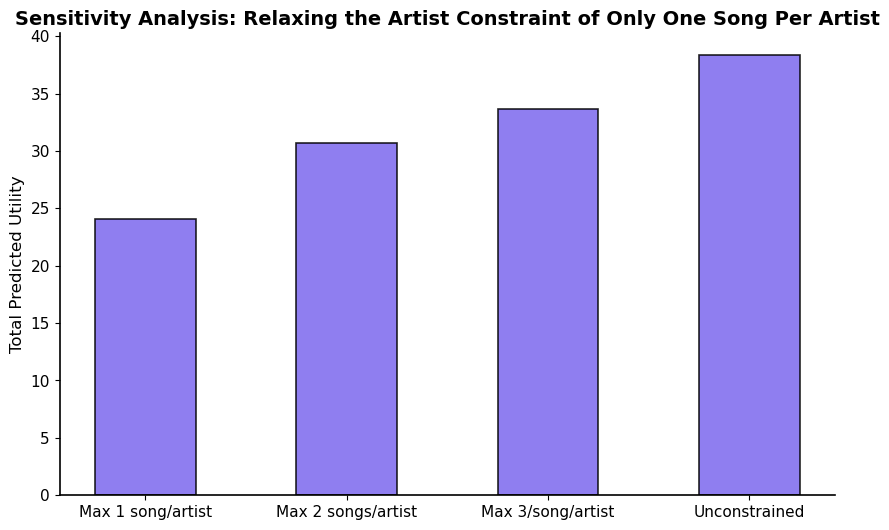

In [27]:
# Sensitivity Analysis: Impact of Relaxing One Song Per Artist Constraints
import matplotlib.pyplot as plt

# Load data
df_songs = pd.read_csv('songs_with_predictions_small.csv')
target_user = "user_5c0cba28e67a99c235ef2ba9877fef44"
ratings = df_songs[target_user].tolist()
track_names = df_songs['track_name'].tolist()
artists = df_songs['artist_name'].tolist()
unique_artists = list(set(artists))
num_tracks = len(track_names)

# Settings
playlist_size = 30
artist_limits = [1, 2, 3, None]  # None = no constraint
utilities = []

for limit in artist_limits:
    m = Model("Artist_Limit_Sensitivity")
    m.setParam('OutputFlag', 0)

    # Decision variables
    x = m.addVars(num_tracks, vtype=GRB.BINARY, name="x")

    # Playlist size constraint
    m.addConstr(quicksum(x[i] for i in range(num_tracks)) == playlist_size, "playlist_size")

    # Add artist limit constraint (if any)
    if limit is not None:
        for artist in unique_artists:
            song_indices = [i for i in range(num_tracks) if artists[i] == artist]
            m.addConstr(quicksum(x[i] for i in song_indices) <= limit, f"artist_limit_{artist}")

    # Objective: maximize utility
    m.setObjective(quicksum(ratings[i] * x[i] for i in range(num_tracks)), GRB.MAXIMIZE)
    m.optimize()

    # Record predicted utility
    total_utility = sum(ratings[i] for i in range(num_tracks) if x[i].X > 0.5)
    utilities.append(total_utility)

# Print results with headers and better formatting
print("=== Sensitivity Analysis Results ===\n")

# Print total utility for each limit
print("Total Predicted Utility:")
for i, limit in enumerate(artist_limits):
    if limit is not None:
        print(f"  Max {limit}/song: {utilities[i]:.2f}")
    else:
        print(f"  No limit: {utilities[i]:.2f}")
print("\n")

# Print playlist utility score for each limit
print("Playlist Utility Score:")
for i, limit in enumerate(artist_limits):
    if limit is not None:
        print(f"  Max {limit}/song: {utilities[i]:.2f}")
    else:
        print(f"  No limit: {utilities[i]:.2f}")
print("\n")

# Display the artists selected for each limit
for i, limit in enumerate(artist_limits):
    m = Model("Artist_Limit_Sensitivity")
    m.setParam('OutputFlag', 0)

    # Decision variables
    x = m.addVars(num_tracks, vtype=GRB.BINARY, name="x")

    # Playlist size constraint
    m.addConstr(quicksum(x[i] for i in range(num_tracks)) == playlist_size, "playlist_size")

    # Add artist limit constraint (if any)
    if limit is not None:
        for artist in unique_artists:
            song_indices = [i for i in range(num_tracks) if artists[i] == artist]
            m.addConstr(quicksum(x[i] for i in song_indices) <= limit, f"artist_limit_{artist}")

    # Objective: maximize utility
    m.setObjective(quicksum(ratings[i] * x[i] for i in range(num_tracks)), GRB.MAXIMIZE)
    m.optimize()

    # Extract selected tracks
    selected_indices = [i for i in range(num_tracks) if x[i].X > 0.5]
    selected_tracks = df_songs.iloc[selected_indices].copy()

    # Print the total number of songs selected
    print(f"Total songs selected with max {limit}/song: {len(selected_indices)}")

    # Count the number of songs selected per artist
    artist_counts = selected_tracks['artist_name'].value_counts()

    print(f"Artists selected with max {limit}/song:")
    for artist, count in artist_counts.items():
        print(f"  {artist}: {count} songs")
    print("\n")


# Plotting results
labels = ['Max 1 song/artist', 'Max 2 songs/artist', 'Max 3/song/artist', 'Unconstrained']
plt.figure(figsize=(10, 6))
bar_width = 0.5  # Adjust the bar width to make the bars skinnier
plt.bar(labels, utilities, width=bar_width, color='mediumslateblue', alpha=0.85, edgecolor='black', linewidth=1.2)
plt.ylabel("Total Predicted Utility", fontsize=12)
plt.title("Sensitivity Analysis: Relaxing the Artist Constraint of Only One Song Per Artist", fontsize=14, fontweight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(False)  # Remove grid lines
plt.gca().spines['top'].set_visible(False)  # Remove top border
plt.gca().spines['right'].set_visible(False)  # Remove right border
plt.gca().spines['left'].set_linewidth(1.2)  # Adjust left border width
plt.gca().spines['bottom'].set_linewidth(1.2)  # Adjust bottom border width
plt.show()